In [1]:
import requests
import time
import datetime
import pandas as pd
from config import email, key
import matplotlib.pyplot as plt
import json
import numpy

In [2]:
events = ["ci37908735","ci37374687","nc72282711","ci10736069",
          "ci14383980","nc40204628"]

i=0

earthquakes_list = []

for event in events:
    base_url = "https://earthquake.usgs.gov/fdsnws/event/1/query?format=geojson"
    times_url = "&starttime=1990-01-01&endtime=2019-06-15"
    magnitude_url ="&minmagnitude=5.0"
    #geometry_url = "&minlatitude=32.43&maxlatitude=42.05&minlongitude=-124.28&maxlongitude=-114.11"
    eventid_url = f"&eventid={event}"
    
    search = requests.get(base_url + times_url + magnitude_url + eventid_url)
    
    response = search.json()

    identifier = response['id']
    mag = response['properties']['mag']
    url = response['properties']['url']
    epochtime = response['properties']['time']
    four_weeks_before = epochtime - 2419200000
    four_weeks_after = epochtime + 2419200000
    event_date= time.strftime('%Y%m%d',  time.gmtime(epochtime/1000))
    month_before= time.strftime('%Y%m%d',  time.gmtime(four_weeks_before/1000))
    month_after = time.strftime('%Y%m%d',  time.gmtime(four_weeks_after/1000))
    converted_time = time.strftime('%H:%M:%S',  time.gmtime(epochtime/1000))
    timezone=response['properties']['tz']
    place = response['properties']['place']
    significance=response['properties']['sig']
    lon = response['geometry']['coordinates'][0]
    lat = response['geometry']['coordinates'][1]
    depth = response['geometry']['coordinates'][2]
    record_dict = {"Identifier":identifier, "Location":place, "Magnitude":mag, "Event Date":event_date,
                   "Month Before":month_before, "Month After":month_after, "Time":converted_time,"Time Zone":timezone, 
                   "Significance":significance, "Lat":lat, "Lon":lon, "Depth":depth, "Epoch Time":epochtime}
    earthquakes_list.append(record_dict)
        
    i += 1
          
earthquakes_df = pd.DataFrame(earthquakes_list)

earthquakes_df = earthquakes_df[~earthquakes_df["Location"].str.contains("Mexico")]

earthquakes_df = earthquakes_df[~earthquakes_df["Location"].str.contains("MX")]

earthquakes_df = earthquakes_df[~earthquakes_df["Location"].str.contains("Nevada")]

earthquakes_df = earthquakes_df[~earthquakes_df["Location"].str.contains("NV")].reset_index()

earthquakes_df = earthquakes_df.fillna(value="")

earthquakes_abbrev =earthquakes_df[['Location', 'Event Date', 'Magnitude']]

pd.set_option('display.max_rows', None)

earthquakes_df.to_csv("DataFiles/earthquake_list.csv")

earthquakes_df 

,index,Identifier,Location,Magnitude,Event Date,Month Before,Month After,Time,Time Zone,Significance,Lat,Lon,Depth,Epoch Time
0,0,ci37908735,"29km SW of Santa Cruz Is. (E end), CA",5.29,20180405,20180308,20180503,19:29:16,-480,1011,33.837500,-119.725833,9.870,1522956556500
1,1,ci37374687,"20km NNW of Borrego Springs, CA",5.19,20160610,20160513,20160708,08:04:38,-420,1014,33.431500,-116.442667,12.310,1465545878700
2,2,nc72282711,South Napa,6.02,20140824,20140727,20140921,10:20:44,-420,2750,38.215167,-122.312333,11.120,1408875644070
3,3,ci10736069,"20km NNW of Borrego Springs, CA",5.42,20100707,20100609,20100804,23:53:33,-480,1032,33.417333,-116.474667,12.318,1278546813480
4,4,ci14383980,"5km S of Chino Hills, CA",5.44,20080729,20080701,20080826,18:42:15,,1095,33.948500,-117.766333,15.503,1217356935670
5,5,nc40204628,"San Francisco Bay area, California",5.45,20071031,20071003,20071128,03:04:54,,1067,37.433500,-121.774333,9.741,1193799894810


In [3]:
earthquake = 0
record_list = []

for rows in earthquakes_df.iterrows():

    # base_url finds air quality readings by Box with daily summaries 

    base_url = "https://aqs.epa.gov/data/api/dailyData/byBox?"

    #parameters for byBox for CRITERIA Pollutants 
    #42401 = "Sulfur Dioxide" 
    #42602 = "Nitrogen Dioxide"
    #44201 = "Ozone"
    #42101 = "Carbon Monoxide"
    #81102 = "PM10 Total 0-10 um STP"
    #88101 = "PM2.5 - Local Conditions"

    begin = earthquakes_df.iloc[earthquake, 5]
    end = earthquakes_df.iloc[earthquake, 6]
    minlat=earthquakes_df.iloc[earthquake,10]-1
    maxlat=earthquakes_df.iloc[earthquake,10]+1
    minlon=earthquakes_df.iloc[earthquake,11]-1
    maxlon=earthquakes_df.iloc[earthquake,11]+1
    earthquake_location=earthquakes_df.iloc[earthquake,2]
    event_date =earthquakes_df.iloc[earthquake, 4]
    identifier = earthquakes_df.iloc[earthquake,1]
    
    param_url = f"param=42401,42602,44201,42101,81102,88101"
    date_range_url = f"&bdate={begin}&edate={end}"
    geometry_url = f"&minlat={minlat}&maxlat={maxlat}&minlon={minlon}&maxlon={maxlon}"

    url = (base_url + param_url + "&email=" + email + "&key=" + key + date_range_url + geometry_url)
    
    print(url)
    
    print(earthquake_location+" "+event_date)
    
    search = requests.get(url)
    responses = search.json()
    
    i = 0
    
    for record in responses['Data']:
        site = responses['Data'][i]['local_site_name']
        station = responses['Data'][i]['site_number']
        parameter = responses['Data'][i]['parameter']
        date = responses['Data'][i]['date_local']
        measurement = responses['Data'][i]['arithmetic_mean']
        measurement_unit = responses['Data'][i]['units_of_measure']
        event_type=responses['Data'][i]["event_type"]
        lon = responses['Data'][i]['longitude']
        lat = responses['Data'][i]['latitude']
        earthquake_id = earthquakes_df.iloc[earthquake, 1]
        record_dict = {"Earthquake ID":earthquake_id,"Parameter":parameter,"Date":date,"Station":station,"Site":site, 
                        "Lat":lat,"Lon":lon, "Measurement":measurement, "Unit":measurement_unit,"Event Type":event_type}
        record_list.append(record_dict)

        i += 1
    
    earthquake += 1

print('Seaches Completed')

https://aqs.epa.gov/data/api/dailyData/byBox?param=42401,42602,44201,42101,81102,88101&email=ronneimark@hotmail.com&key=tawnybird31&bdate=20180308&edate=20180503&minlat=32.8375&maxlat=34.8375&minlon=-120.7258333&maxlon=-118.7258333
29km SW of Santa Cruz Is. (E end), CA 20180405
https://aqs.epa.gov/data/api/dailyData/byBox?param=42401,42602,44201,42101,81102,88101&email=ronneimark@hotmail.com&key=tawnybird31&bdate=20160513&edate=20160708&minlat=32.4315&maxlat=34.4315&minlon=-117.4426667&maxlon=-115.4426667
20km NNW of Borrego Springs, CA 20160610
https://aqs.epa.gov/data/api/dailyData/byBox?param=42401,42602,44201,42101,81102,88101&email=ronneimark@hotmail.com&key=tawnybird31&bdate=20140727&edate=20140921&minlat=37.2151667&maxlat=39.2151667&minlon=-123.3123333&maxlon=-121.3123333
South Napa 20140824
https://aqs.epa.gov/data/api/dailyData/byBox?param=42401,42602,44201,42101,81102,88101&email=ronneimark@hotmail.com&key=tawnybird31&bdate=20100609&edate=20100804&minlat=32.4173333&maxlat=34.

In [4]:
record_df = pd.DataFrame(record_list)
pd.set_option('display.max_rows', 100)
record_df

,Earthquake ID,Parameter,Date,Station,Site,Lat,Lon,Measurement,Unit,Event Type
0,ci37908735,PM10 Total 0-10um STP,2018-03-09,4003,VAFB South Base,34.595900,-120.631315,21.571429,Micrograms/cubic meter (25 C),None
1,ci37908735,PM10 Total 0-10um STP,2018-03-10,4003,VAFB South Base,34.595900,-120.631315,13.500000,Micrograms/cubic meter (25 C),None
2,ci37908735,PM10 Total 0-10um STP,2018-03-11,4003,VAFB South Base,34.595900,-120.631315,14.666667,Micrograms/cubic meter (25 C),None
3,ci37908735,PM10 Total 0-10um STP,2018-03-12,4003,VAFB South Base,34.595900,-120.631315,11.583333,Micrograms/cubic meter (25 C),None
4,ci37908735,PM10 Total 0-10um STP,2018-03-13,4003,VAFB South Base,34.595900,-120.631315,10.875000,Micrograms/cubic meter (25 C),None
...,...,...,...,...,...,...,...,...,...,...
101418,nc40204628,PM10 Total 0-10um STP,2007-11-20,0003,Napa,38.310942,-122.296189,25.000000,Micrograms/cubic meter (25 C),None
101419,nc40204628,PM10 Total 0-10um STP,2007-11-26,0003,Napa,38.310942,-122.296189,38.000000,Micrograms/cubic meter (25 C),None
101420,nc40204628,Ozone,2007-10-31,0009,Oakland,37.743065,-122.169935,0.011000,Parts per million,None
101421,nc40204628,Ozone,2007-10-31,0009,Oakland,37.743065,-122.169935,0.011000,Parts per million,None


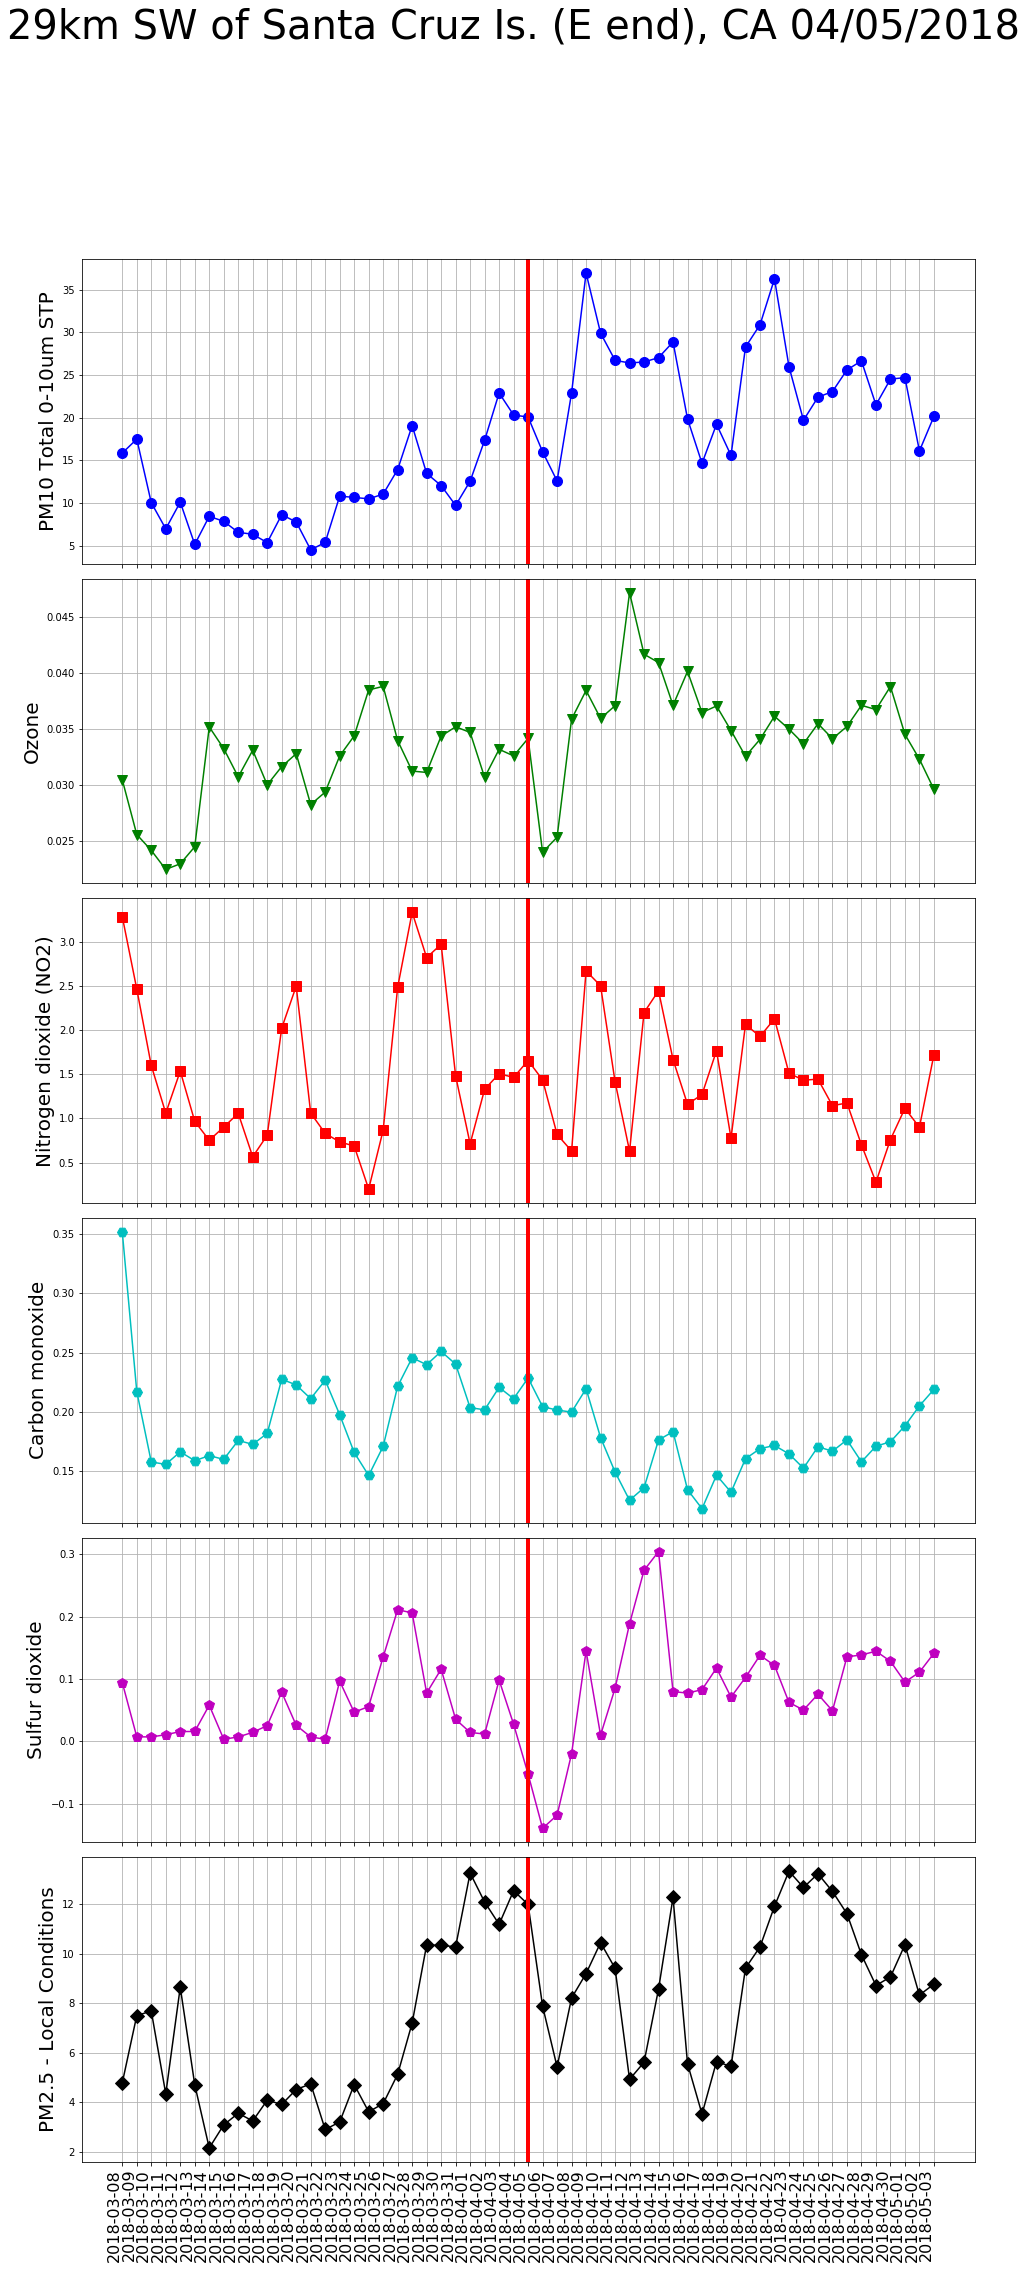

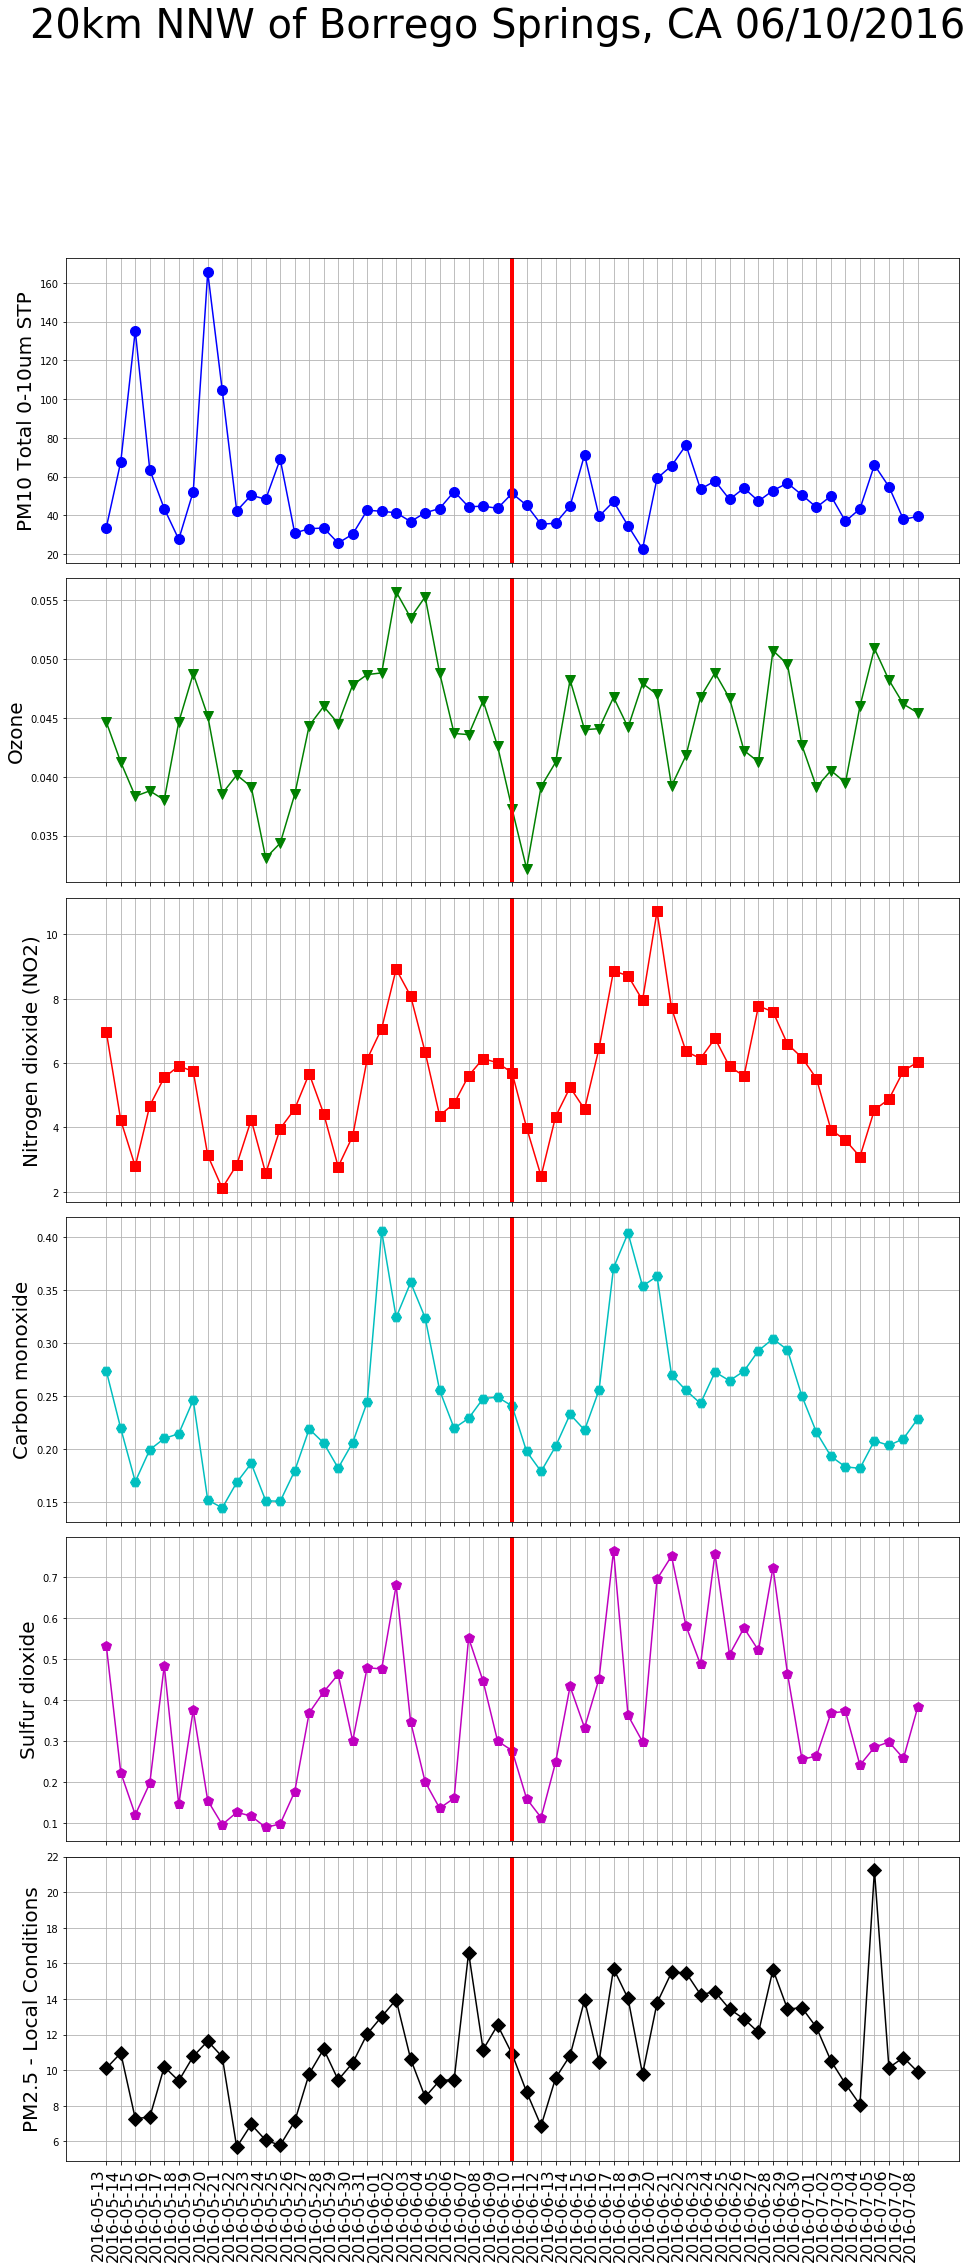

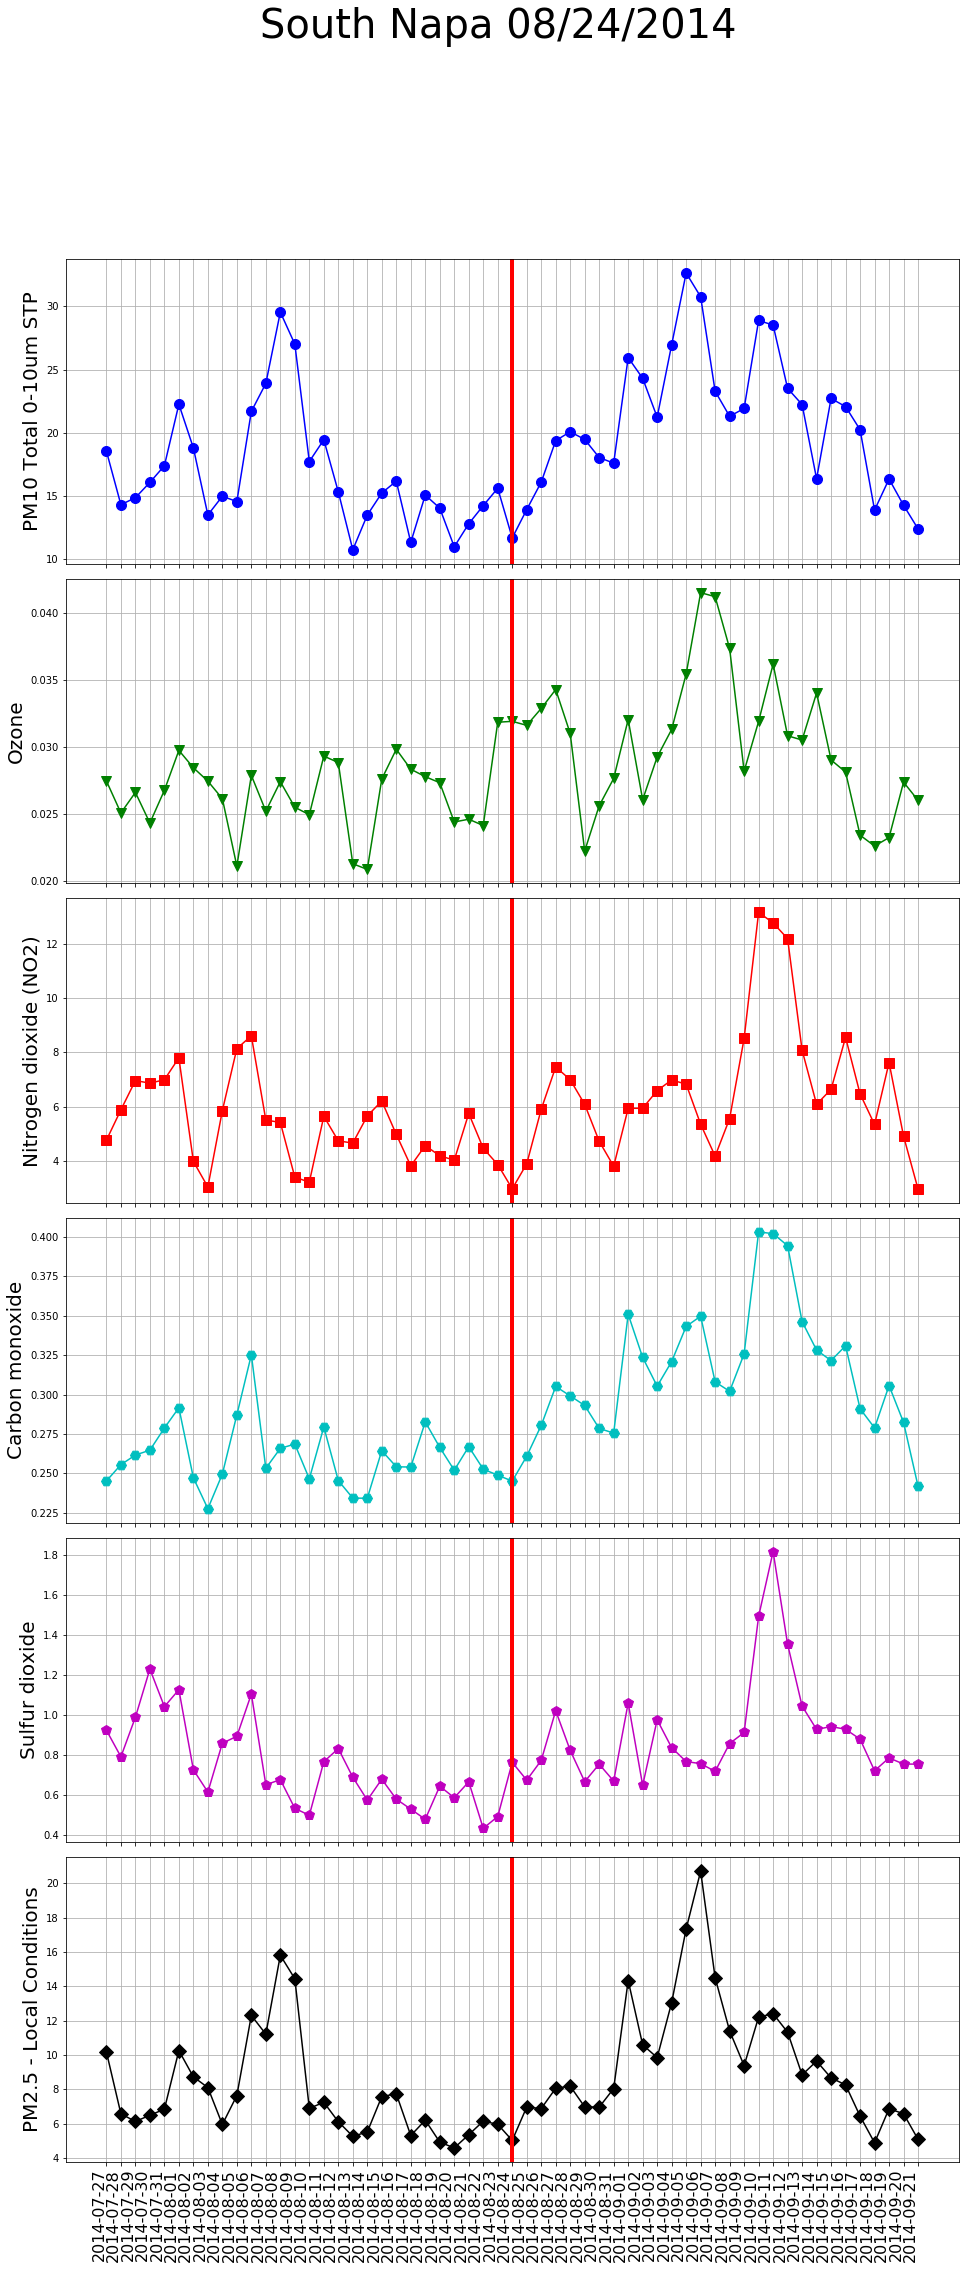

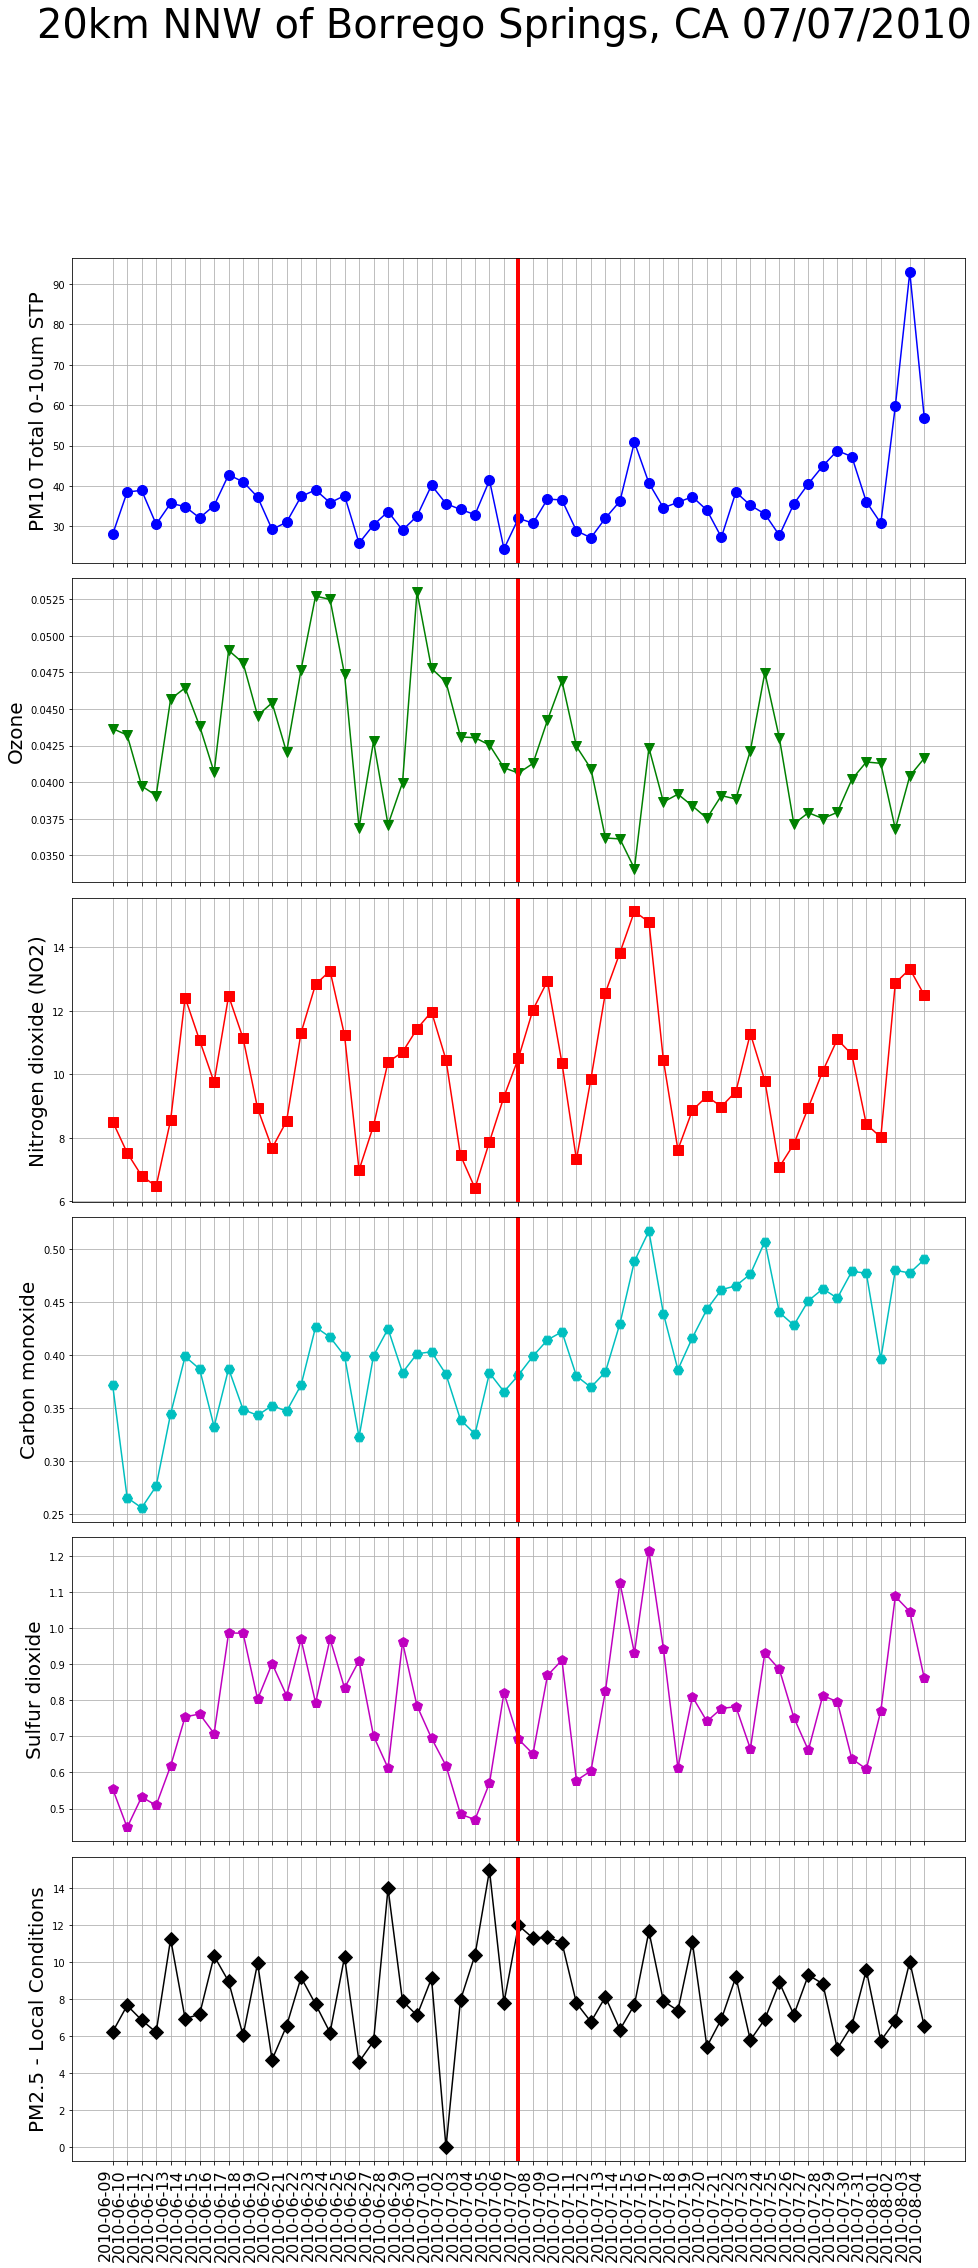

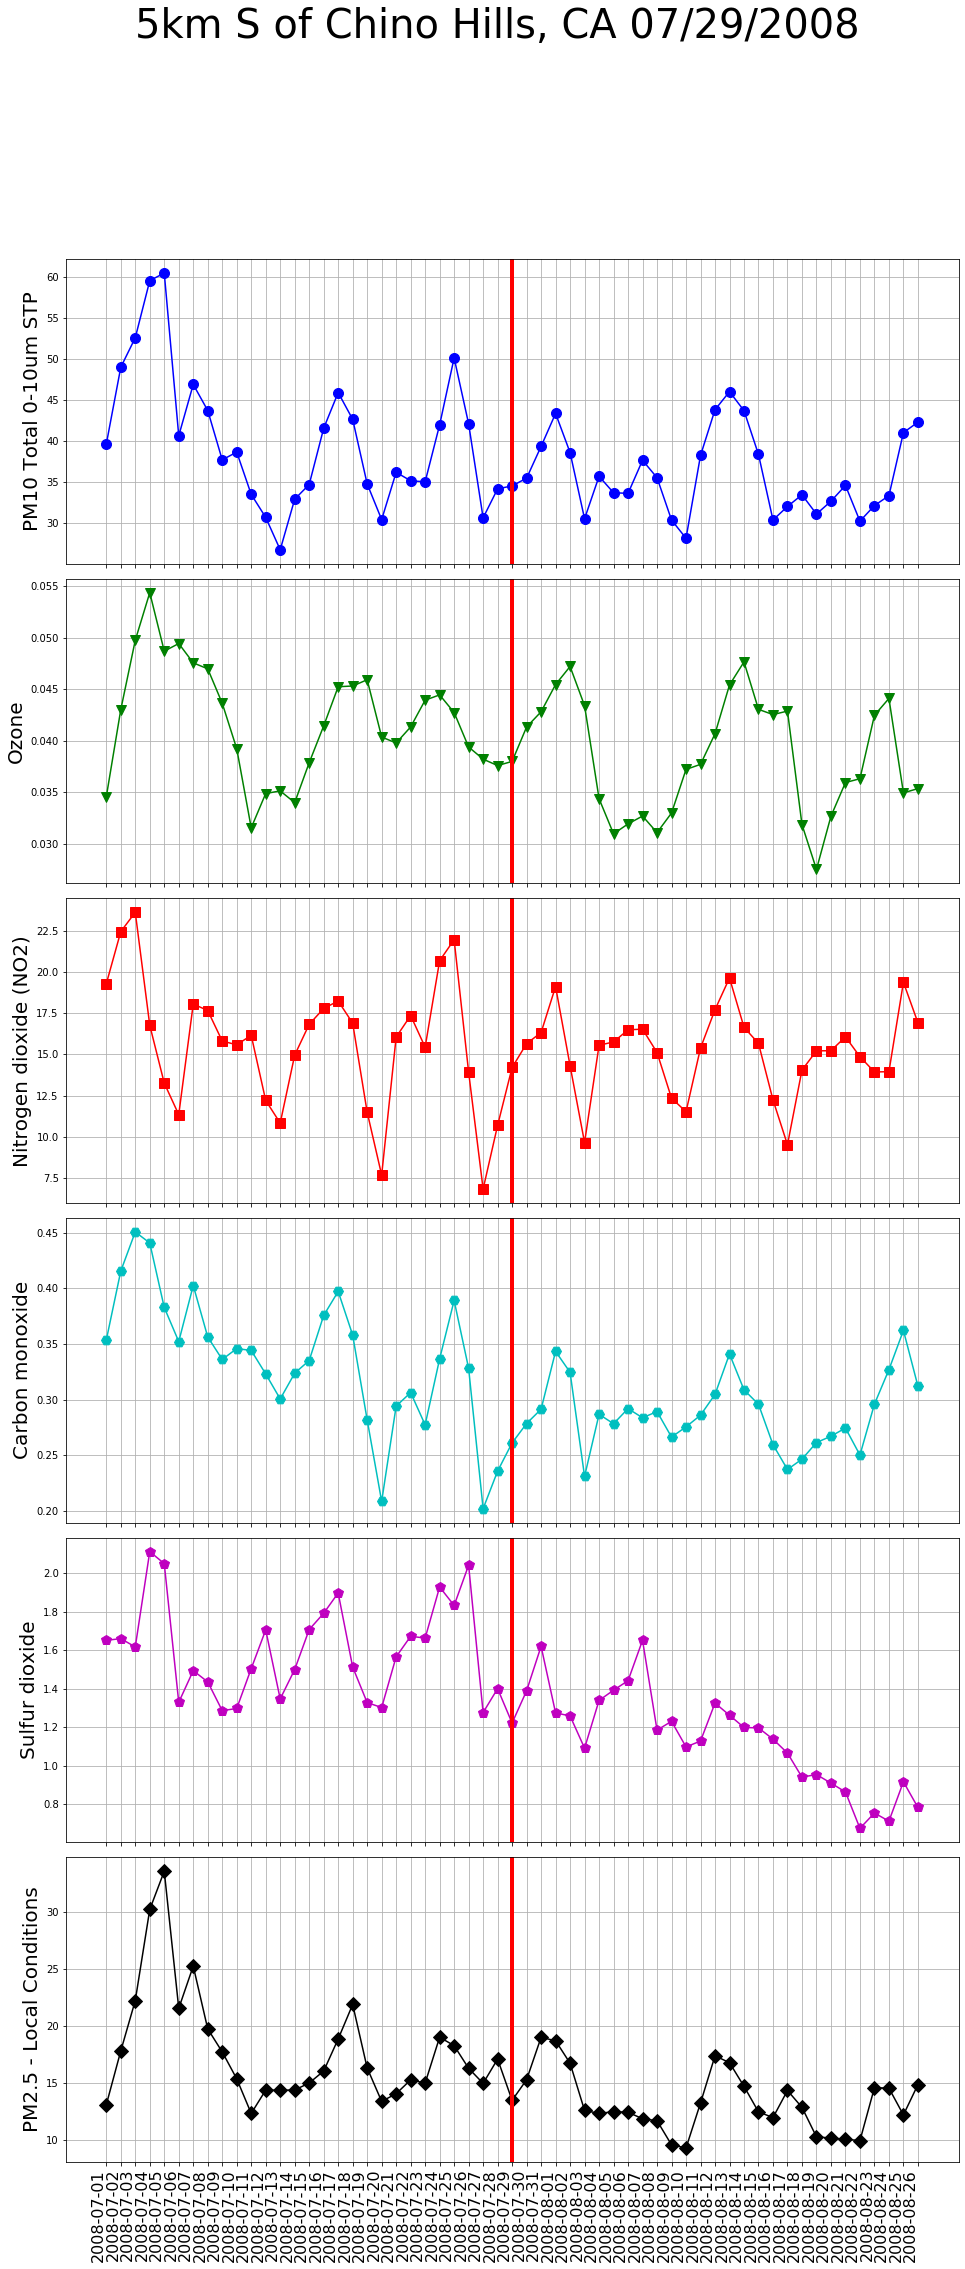

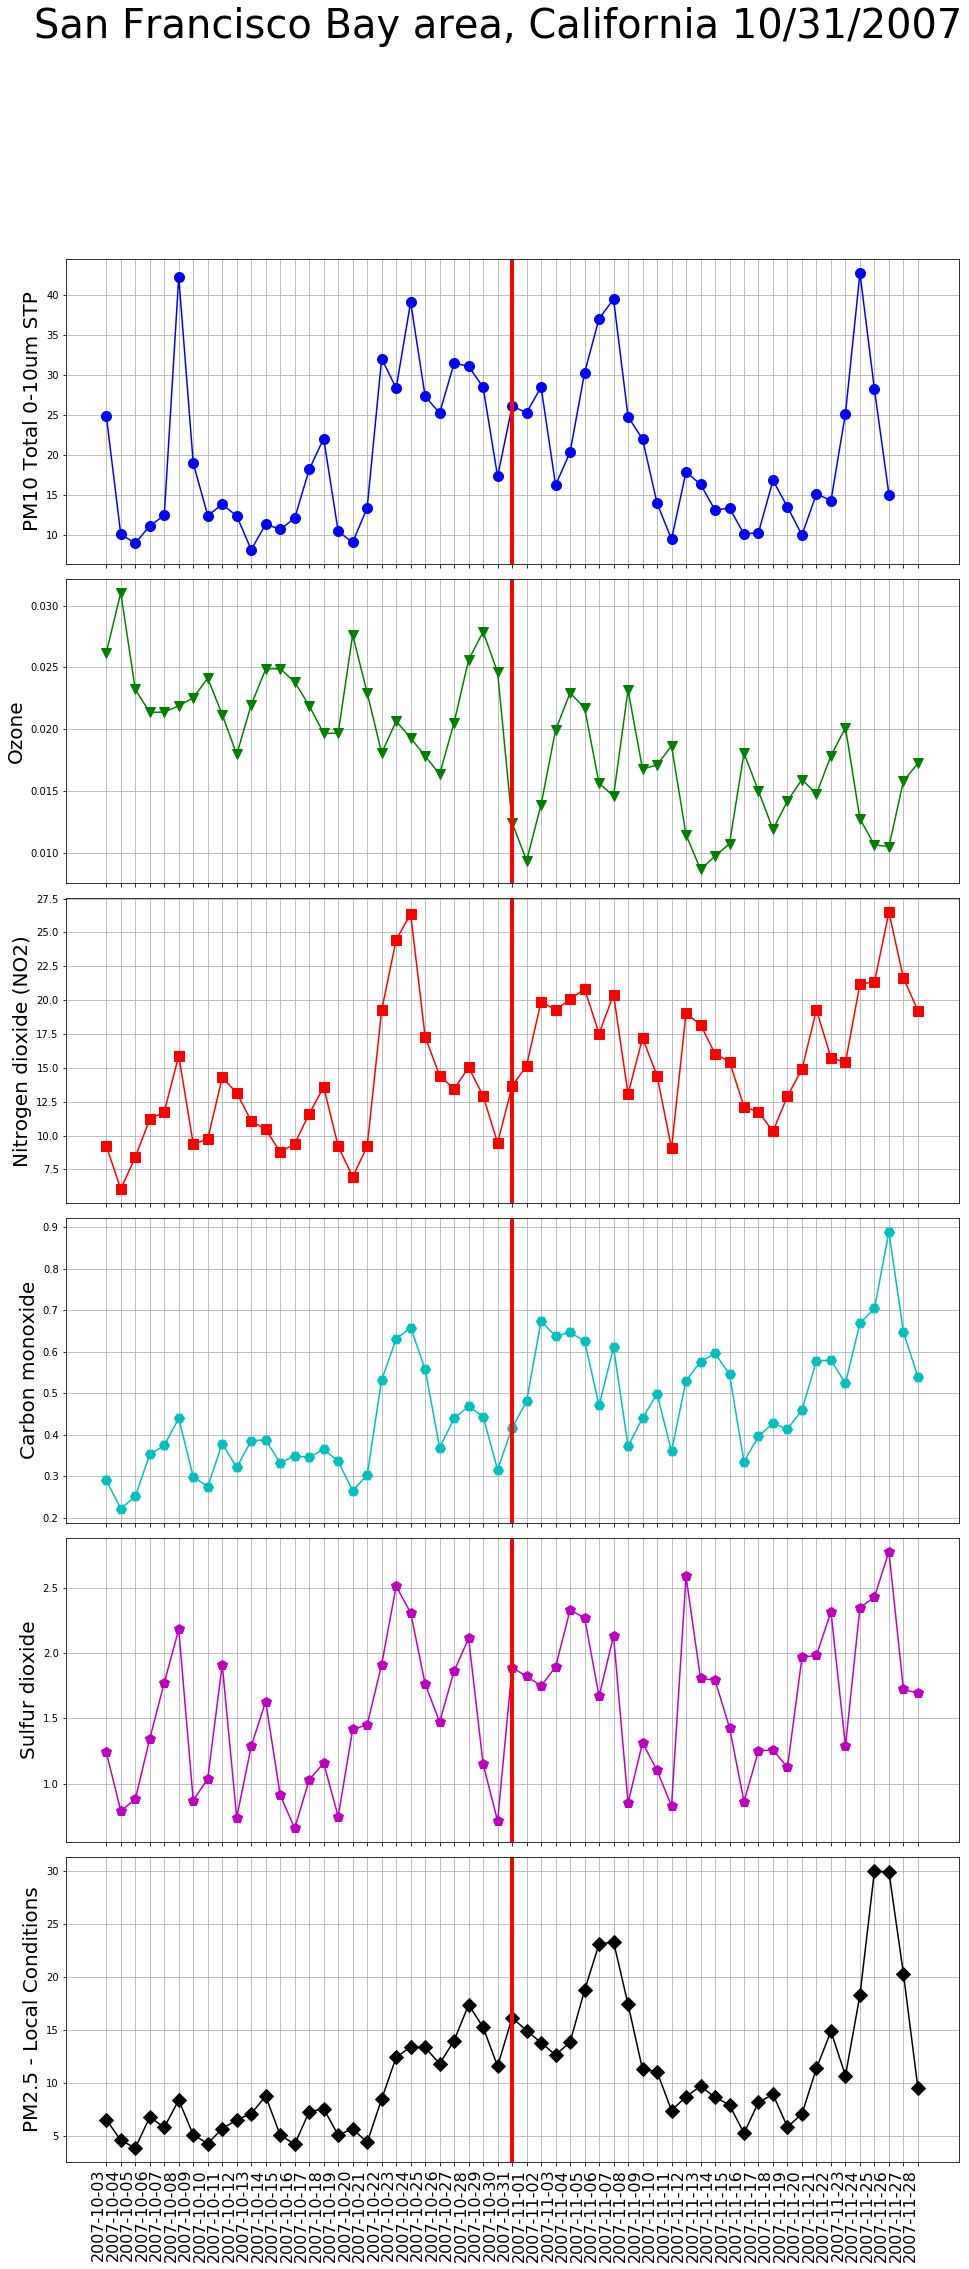

In [17]:
events = earthquakes_df['Identifier'].tolist()
pollutants = record_df['Parameter'].unique().tolist()
colorlines = ['bo', 'gv', 'rs', 'cH', 'mp', 'kD']

earthquake = 0

for event in events:
    
    fig, axs = plt.subplots(6, sharex = True, sharey = False, gridspec_kw={'hspace': .05}, squeeze = True)
    
    
    i=0

    for pollutant in pollutants:
        
        
        epochtime = earthquakes_df.iloc[earthquake, 13]
        fancy_event_date = time.strftime('%m/%d/%Y',  time.gmtime(epochtime/1000))
        eventname = (f'{earthquakes_df.iloc[earthquake,2]} {fancy_event_date}')
    
        aqi_event_date = time.strftime('%Y-%m-%d',  time.gmtime(epochtime/1000))
        earthquake_location=earthquakes_df.iloc[earthquake,2]
        earthquake_id = earthquakes_df.iloc[earthquake, 1]
    
        graph_pollutant = record_df[record_df['Parameter']==pollutant]
        graph_pollutant = graph_pollutant[graph_pollutant['Earthquake ID']==events[earthquake]]
        graph_pollutant = graph_pollutant[['Date','Measurement']].sort_values('Date')
        graph_pollutant = graph_pollutant.groupby(['Date']).mean()
        graph_pollutant = graph_pollutant.reset_index()
        
        axs[i].plot(graph_pollutant['Date'],graph_pollutant['Measurement'],colorlines[i], linestyle='solid', markersize=10)
        fig.suptitle(eventname, fontsize = 40)
        plt.tight_layout
        axs[i].axvline(x=aqi_event_date, color='r', linewidth=4)
        plt.rcParams["figure.figsize"] = [16,35]
        plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
        #axs[i].set_title(titlename)
        plt.setp(axs[i].get_xticklabels(), rotation=90, horizontalalignment='right', fontsize=16)
        axs[i].set_ylabel(pollutant, fontsize = 20)
        axs[i].grid(True)
        plt.tight_layout
        
        i += 1
        
    
    fancy_event_date = time.strftime('%m/%d/%Y',  time.gmtime(epochtime/1000))
    eventname = (f'{earthquakes_df.iloc[earthquake,2]} {fancy_event_date}')
    epochtime = earthquakes_df.iloc[earthquake, 13]
    plt.savefig('Charts/' + earthquake_id)
    plt.show()
    
    earthquake += 1
    